# Hand Gesture Classification
### by Adrian Abraham

## 1 - Package installation
- **tensorflow**: for model creation and predictions
- **pandas**: for csv_reading
- **numpy**: for data storage and manipulation
- **mediapipe**: contains pre-made hand detection module for data collection
- **open-cv**: for live feed
- **ast**: to convert string literal lists into actual lists

In [ ]:
!pip install tensorflow

In [ ]:
!pip install pandas

In [ ]:
!pip install mediapipe

In [ ]:
!pip install scikit-learn

In [ ]:
!pip install matplotlib

## 2 - Importing packages

In [89]:
import os
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ast
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.activations import linear, relu, sigmoid
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import L2

### Quick check that tensorflow is working

In [90]:
print(tf.__version__)

2.16.2


## 3 - Data import and manipulation

Each class data is stored in a csv file, which are collectively stored in the data folder. We will take all the data points and store them in one np array.

In [91]:
# Using glob to get all .csv files in the data folder
csv_names = glob.glob('data/*.csv')
csv_names.sort()
dfs = []
# Every .csv file is read using the pandas library and added to a list of DataFrames
for name in csv_names:
    dfs.append(pd.read_csv(name))

# The ast library is then used to convert the string literal lists into actual lists
# Then, each list is concatenated with each other to form one big np array of data
all_data = []
for df in dfs:
    # For each element in the Series df['coords'], we apply the function ast.literal_eval
    # to turn the string literals into lists
    df['coords'] = df['coords'].apply(ast.literal_eval)

    # The Series df['coords'] is then turned into a list using the tolist() function
    # and finally passed into np.array() to create a np array
    df_as_arr = np.array(df['coords'].tolist())
    
    all_data.append(df_as_arr)
data = np.concatenate(all_data, axis=0)

We can check its shape to verify how many points we have in the dataset and how many hand landmark coordinates are stored in each element.

In [92]:
data.shape

(7494, 21, 2)

Now we can create the target classes for each element of the dataset.

In [93]:
# We are taking each file name and extracting the gesture name
gestures = []
for name in csv_names:
    # We split the name at the '/' and get the last element, the csv file name, and remove the .csv extension
    gesture = name.split('/')[-1].replace('.csv', '')
    gestures.append(gesture)
print(f'Gestures to be detected: {gestures}')

Gestures to be detected: ['heart', 'none', 'peace', 'shaka']


In [94]:
# Generating the target outputs for all dataset
targets = []
for i in range(len(all_data)):
    targets.append(np.full(all_data[i].shape[0], i))
targets = np.concatenate(targets, axis=0)

In [95]:
# Splitting dataset into training set and cross validation set
data_train, data_cv, target_train, target_cv = train_test_split(data, targets, test_size=0.2, random_state=42)

In [96]:
# Creating a Sequential model for our neural network
l = 0.001
model = Sequential([
    Input(shape=data.shape[1:]),                                                    # Define the input shape here
    Flatten(),                                                                      # Flatten the (21, 2) input into a 1D vector
    Dense(32, activation='relu',  name='L1', kernel_regularizer=L2(l)),             # Fully connected layer with 20 neurons
    Dense(16, activation='relu',  name='L2', kernel_regularizer=L2(l)),             # Fully connected layer with 10 neurons
    Dense(len(gestures), activation='linear', name='L3', kernel_regularizer=L2(l))  # Output layer for multiclass classification
])
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_12 (Flatten)            │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L1 (Dense)                      │ (None, 32)             │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L2 (Dense)                      │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L3 (Dense)                      │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,972 (7.70 KB)

 Trainable params: 1,972 (7.70 KB)

 Non-trainable params: 0 (0.00 B)

In [97]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [98]:
history = model.fit(
    data_train,target_train,
    epochs=40,
    validation_data=(data_cv,target_cv),
    verbose=0
)
print("Model successfully trained!")

Model successfully trained!


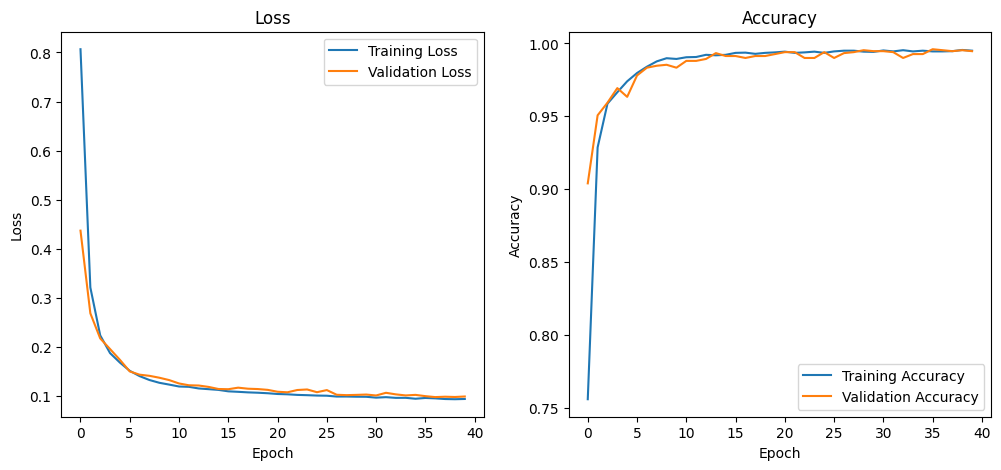

In [99]:
# Plotting learning curves
plt.figure(figsize=(12, 5))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [100]:
model.save("gesture_model.keras")